# import

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from collections import Counter
import tes_analysis_tools as tat

import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.distribution import MultiprocessingDistributor

warnings.filterwarnings("ignore")
sns.set()

# utils

In [15]:
# データ補正 <- 18次回帰曲線
def regression(data, time):
    fit = np.polyfit(time, data, 18)
    fit_fn = np.poly1d(fit)
    return fit_fn(time)


# 標準化
def standardize(df):
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_std


# tsfreshの特徴量に対する前処理
def remove_constant_columns(df):
    df_filtered = df.loc[:, df.nunique() != 1]
    return df_filtered


def remove_binary_columns(df):
    columns_to_select = df.apply(lambda col: not set(col.unique()).issubset({0, 1}))
    df_filtered = df.loc[:, columns_to_select]
    return df_filtered


def remove_constant_or_binary_columns(df):
    columns_to_select = df.apply(lambda col: (col.nunique() != 1) and not set(col.unique()).issubset({0, 1}))
    df_filtered = df.loc[:, columns_to_select]
    return df_filtered


def remove_corr_cols(df, threshold=0.7):
    corr = df.corr().abs()
    high_corr = np.where(corr > threshold)
    to_drop = []
    for idx, col in zip(high_corr[0], high_corr[1]):
        f1, f2 = corr.index[idx], corr.columns[col]
        if f1 != f2 and f1 not in to_drop and f2 not in to_drop:
            to_drop.append(f1)
    df_filtered = df.drop(to_drop, axis=1)
    return df_filtered


def preprocess(df, threshold=0.7):
    df_filtered = remove_constant_or_binary_columns(df)
    df_filtered = standardize(df_filtered)
    df_filtered = remove_corr_cols(df_filtered, threshold)
    return df_filtered


# 主成分分析の特徴量に対する前処理
# 第一主成分の平均値が低いクラスタから0, 1, ...と再ラベリング
def relabel_by_first_component_avg(label_col, pca_df):
    relabeled_pca_df = pca_df.copy()
    first_component_avg_per_cluster = {}
    for label in set(pca_df[label_col]):
        if label != -1:
            first_component_avg_per_cluster[label] = pca_df[pca_df[label_col] == label]["first_component"].mean()
    sorted_keys = sorted(first_component_avg_per_cluster, key=lambda x: first_component_avg_per_cluster[x])
    relabel_dict = {k: v for v, k in enumerate(sorted_keys)}
    relabel_dict[-1] = -1
    relabeled_pca_df[label_col] = relabeled_pca_df[label_col].map(relabel_dict)
    return relabeled_pca_df

# データ読み込み、作成

Shaping ... 
number of selected pulses =  10000


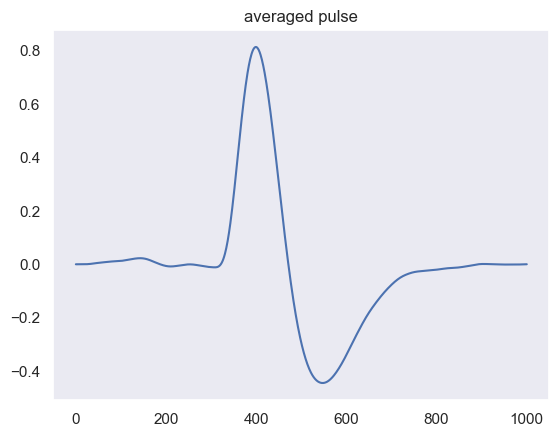

max pulse height =  0.014150716822372296
min pulse height =  8.63413854979736e-06


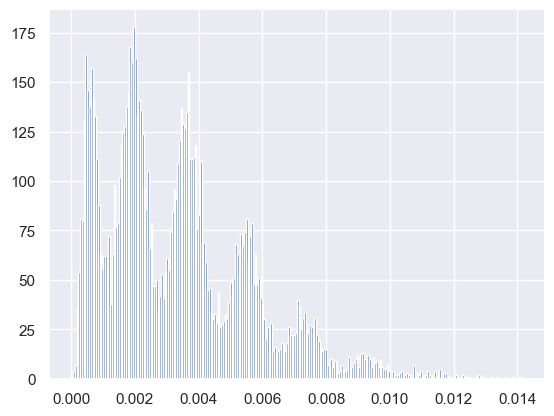

Optimal filtering started ...
|N(f)|^2 =  [0.46481942 0.30328074 0.31248413 ... 0.3262508  0.31248413 0.30328074]
|M(f)|^2 =  [8.82221935e-03 4.91831404e+03 9.47976336e+03 ... 8.81802291e+03
 9.47976336e+03 4.91831404e+03]
max frequency =  1000000.0
max frequency index =  50
0.0 %  ( 0 pulses processed )


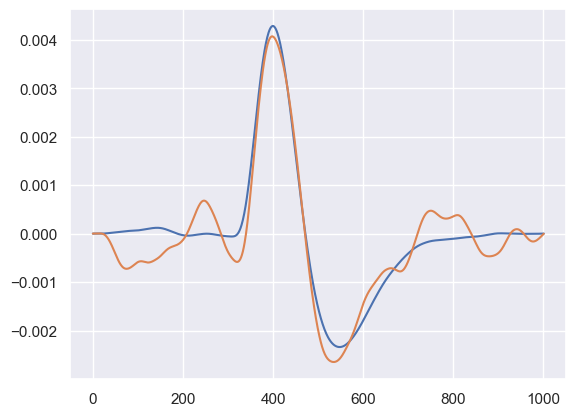

10.0 %  ( 1000 pulses processed )


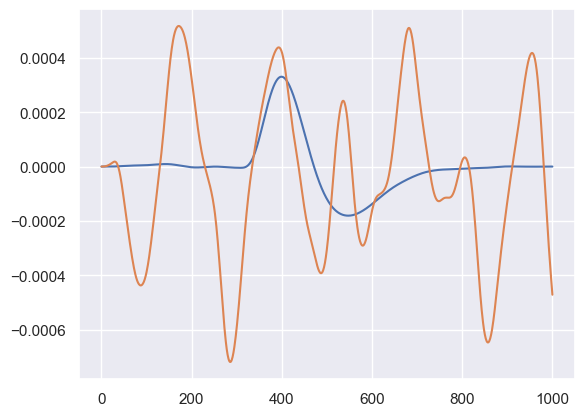

20.0 %  ( 2000 pulses processed )


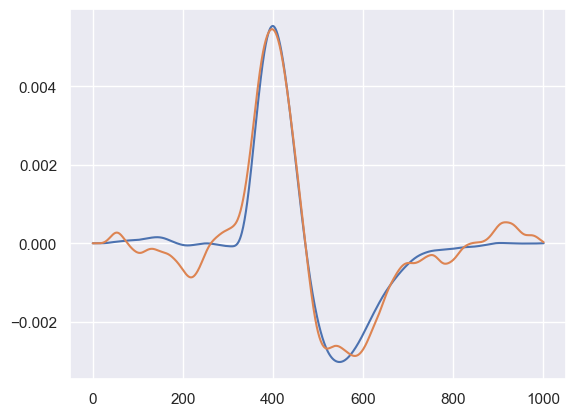

30.0 %  ( 3000 pulses processed )


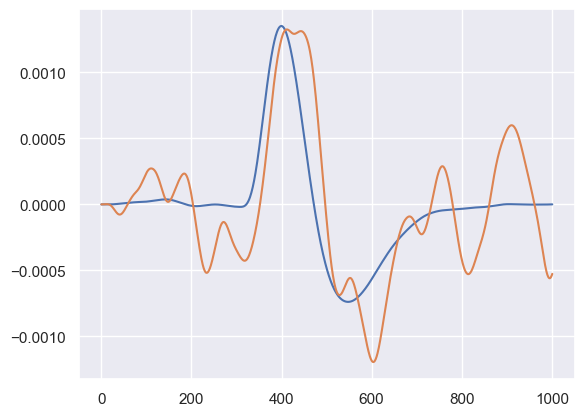

40.0 %  ( 4000 pulses processed )


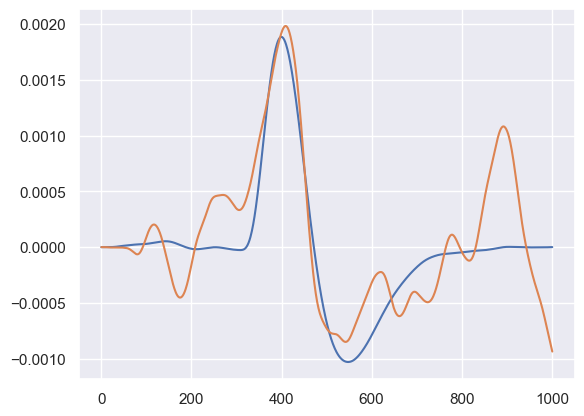

50.0 %  ( 5000 pulses processed )


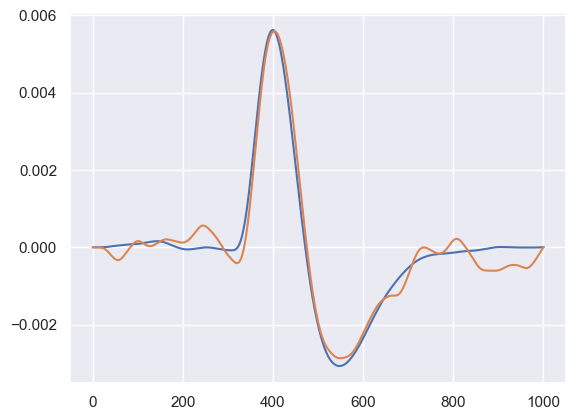

60.0 %  ( 6000 pulses processed )


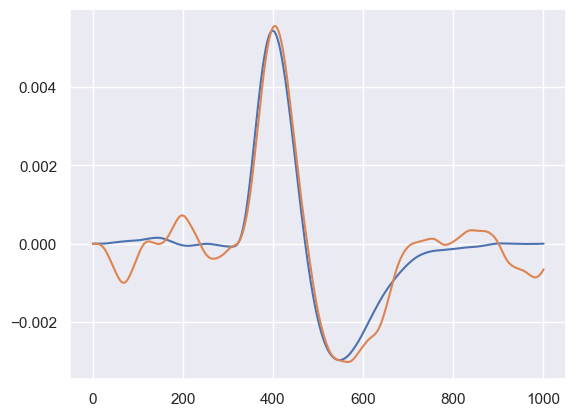

70.0 %  ( 7000 pulses processed )


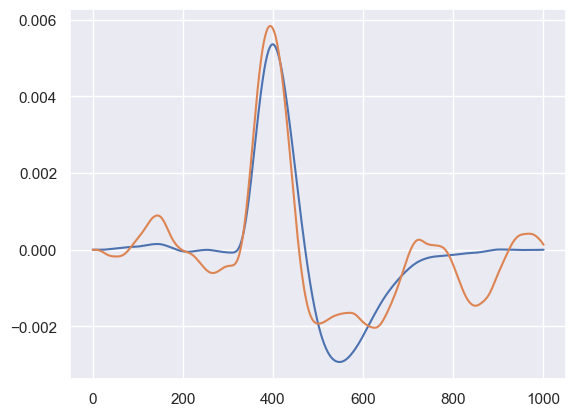

80.0 %  ( 8000 pulses processed )


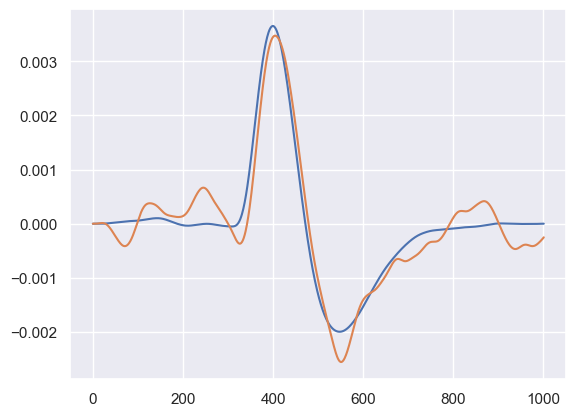

90.0 %  ( 9000 pulses processed )


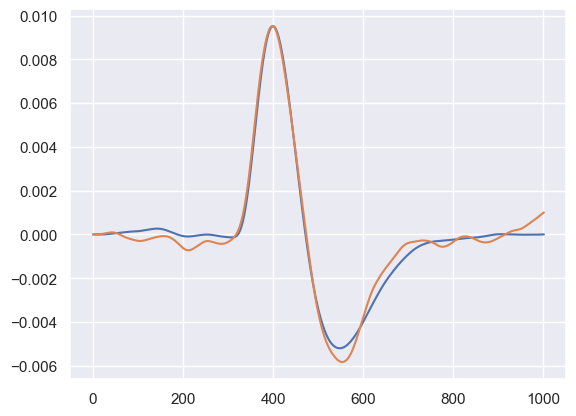

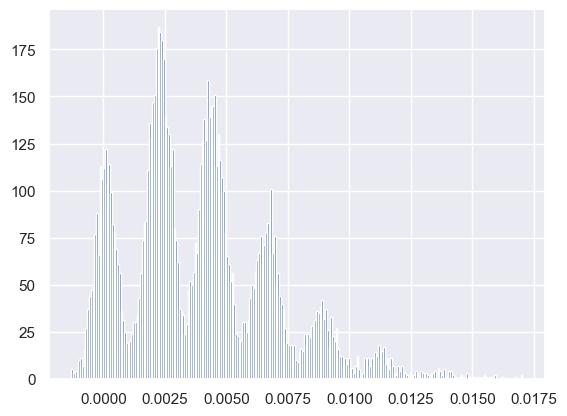

Optimal filtering done.


In [16]:
# -----------------------
# データ読み込み
# -----------------------

dir = "../WF/exp1/"
savedir = "./exp1_result/"
pulse = np.load(dir + "pulse.npy")
noise = np.load(dir + "noise.npy")
time = np.load(dir + "time.npy")

n = pulse.shape[0]
dp = pulse.shape[1]
m = noise.shape[0]
dt = time[1] - time[0]

# baseline 補正, 先頭からdpbl点の平均をoffsetとして引き去る
dpbl = 200
pulse = tat.correct_baseline(pulse, dpbl)

# 正負反転
pulse = -1.0 * pulse

# ------------------------------------
#  従来型の波形処理
# ------------------------------------

# 波形整形
pulse = tat.shaping(pulse, dt, 1.0e-6, 1.0e-6, True)

# 平均波形
avg = tat.make_average_pulse(pulse, 0.0, 1.0, 200, 500, True, True, True)

# 単純波高値
tat.simple_ph_spectrum(pulse, 200, 500, True, True)

# 最適フィルタ
ph, hist = tat.optimal_filter_freq(pulse, avg, noise, dt, 1.0e6, True, True)

# ------------------------------------
#  教師データ作成
# ------------------------------------

# 平均波形を規格化
avg = avg / np.max(avg)

# 最適フィルタの結果から、1光子当たりの波高値を得る
# 今回のデータではおよそ15mV
ph_per_photon = 0.015

# 以下の方法で波形データをシミュレーションできる
# (規格化した平均波形) x (1光子当たりの波高値) x (光子数) + ノイズ
train_data = []
photon_num_list_train = []
noise_rate = 0.5
for _ in range(len(noise)):
    np.random.seed(_)
    num = int(7 * np.random.rand())
    simulation_data = avg * ph_per_photon * num + noise[_, :] * noise_rate
    train_data.append(simulation_data)
    photon_num_list_train.append(num)
train_df = pd.DataFrame(train_data)
train_df["photon_count"] = photon_num_list_train

# バリデーションデータ
train_X, eval_X, train_y, eval_y = train_test_split(train_df.iloc[:, :-1], train_df.iloc[:, -1], test_size=0.2)
train_df = pd.concat([train_X, train_y], axis=1)
eval_df = pd.concat([eval_X, eval_y], axis=1)

# テストデータ
test_df = pd.DataFrame(pulse)

# テストデータを曲線にフィッティングする場合
test_df = test_df.apply(regression, args=(time,), axis=1, result_type="expand")

# 教師ありクラスタリングモデル

In [20]:
class SupervisedClassificationModel:
    def __init__(self, train_df, eval_df, test_df, features_create_method, classification_method):
        # train_df, test_df: 生パルスデータ
        self.train_df = train_df
        self.test_df = test_df
        self.eval_df = eval_df
        self.train_y_df = train_df[["photon_count"]]
        self.eval_y_true_df = eval_df[["photon_count"]]
        self.features_create_method = features_create_method
        self.create_features(features_create_method)
        self.classification(classification_method)
        self.train_features_df = pd.concat([self.train_X_df, self.train_y_df], axis=1)
        self.eval_features_df = pd.concat([self.eval_X_df, self.eval_y_df], axis=1)
        self.test_features_df = pd.concat([self.test_X_df, self.test_y_df], axis=1)
        if self.features_create_method == "PCA":
            self.eval_features_df = relabel_by_first_component_avg("y_pred", self.eval_features_df)
            self.test_features_df = relabel_by_first_component_avg("y_pred", self.test_features_df)

    # 特徴量生成
    def create_features(self, features_create_method):
        # 主成分分析
        if features_create_method == "PCA":
            print("PCA processing ...")
            pca_model = PCA(n_components=2)
            train_X_pca = pca_model.fit_transform(self.train_df.iloc[:, :-1])
            eval_X_pca = pca_model.transform(self.eval_df)
            test_X_pca = pca_model.transform(self.test_df)
            self.train_X_df = pd.DataFrame(train_X_pca, columns=["first_component", "second_component"])
            self.eval_X_df = pd.DataFrame(eval_X_pca, columns=["first_component", "second_component"])
            self.test_X_df = pd.DataFrame(test_X_pca, columns=["first_component", "second_component"])
        # tsfresh
        elif features_create_method == "tsfresh":
            print("tsfresh processing ...")
            tsfresh_features_train_file_path = "../data/tsfresh_features_train.csv"
            tsfresh_features_eval_file_path = "../data/tsfresh_features_eval.csv"
            tsfresh_features_test_file_path = "../data/tsfresh_features_test.csv"
            if os.path.isfile(tsfresh_features_train_file_path) and os.path.isfile(tsfresh_features_eval_file_path) and os.path.isfile(tsfresh_features_test_file_path):
                extracted_features_train = pd.read_csv(tsfresh_features_train_file_path)
                extracted_features_eval = pd.read_csv(tsfresh_features_eval_file_path)
                extracted_features_test = pd.read_csv(tsfresh_features_test_file_path)
                common_features = extracted_features_train.columns.intersection(extracted_features_eval).intersection(extracted_features_test.columns)
                print(f"selected features: {len(common_features)}")
                self.train_X_df = extracted_features_train[common_features]
                self.eval_X_df = extracted_features_eval[common_features]
                self.test_X_df = extracted_features_test[common_features]
            else:
                # tsfreshに対応した形に変換
                # train
                train_tsfresh = self.train_df.iloc[:, :-1].stack().reset_index()
                train_tsfresh.columns = ["id", "time", "voltage"]
                train_tsfresh["id"] = train_tsfresh["id"].astype("object")
                train_tsfresh["time"] = train_tsfresh["time"].astype("object")
                # eval
                eval_tsfresh = self.eval_df.stack().reset_index()
                eval_tsfresh.columns = ["id", "time", "voltage"]
                eval_tsfresh["id"] = eval_tsfresh["id"].astype("object")
                eval_tsfresh["time"] = eval_tsfresh["time"].astype("object")
                # test
                test_tsfresh = self.test_df.stack().reset_index()
                test_tsfresh.columns = ["id", "time", "voltage"]
                test_tsfresh["id"] = test_tsfresh["id"].astype("object")
                test_tsfresh["time"] = test_tsfresh["time"].astype("object")
                # tsfreshによる特徴量作成
                # train
                distributor_train = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
                extracted_features_train = extract_features(train_tsfresh, column_id="id", column_sort="time", distributor=distributor_train)
                # eval
                distributor_eval = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
                extracted_features_eval = extract_features(eval_tsfresh, column_id="id", column_sort="time", distributor=distributor_eval)
                # test
                distributor_test = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
                extracted_features_test = extract_features(test_tsfresh, column_id="id", column_sort="time", distributor=distributor_test)
                impute(extracted_features_train)
                impute(extracted_features_eval)
                impute(extracted_features_test)
                extracted_features_train = preprocess(extracted_features_train)
                extracted_features_eval = preprocess(extracted_features_eval)
                extracted_features_test = preprocess(extracted_features_test)
                # csvファイルに保存
                extracted_features_train.to_csv("../data/tsfresh_features_train.csv", index=False)
                extracted_features_eval.to_csv("../data/tsfresh_features_eval.csv", index=False)
                extracted_features_test.to_csv("../data/tsfresh_features_test.csv", index=False)
                common_features = extracted_features_train.columns.intersection(extracted_features_eval.columns).intersection(extracted_features_test.columns)
                print(f"selected features: {len(common_features)}")
                self.train_X_df = extracted_features_train[common_features]
                self.eval_X_df = extracted_features_eval[common_features]
                self.test_X_df = extracted_features_test[common_features]

    # 分類
    def classification(self, classification_method):
        if classification_method == "logistic regression":
            model = LogisticRegression()
        elif classification_method == "decision tree":
            model = DecisionTreeClassifier()
        elif classification_method == "random forest":
            model = RandomForestClassifier()
        elif classification_method == "support vector machine":
            model = SVC()
        elif classification_method == "k neighbors classifier":
            model = KNeighborsClassifier()
        elif classification_method == "naive bayes":
            model = GaussianNB()
        print(f"training {classification_method} ...")
        model.fit(self.train_X_df.values, self.train_y_df.values)
        y_pred_eval = model.predict(self.eval_X_df.values)
        y_pred_test = model.predict(self.test_X_df.values)
        self.eval_y_df = pd.DataFrame(y_pred_eval, columns=["y_pred"])
        self.test_y_df = pd.DataFrame(y_pred_test, columns=["y_pred"])
    
    # 精度評価
    def evaluation(self):
        cm = confusion_matrix(self.eval_y_true_df.values, self.eval_y_df)
        
        # 混同行列をヒートマップとして表示
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    # testデータの光子数予測のヒストグラム
    def plot_hist(self):
        plt.hist(self.test_y_df["y_pred"], bins=128)
        plt.show()

    # 特徴量作成手法がPCAの場合の第1, 第2主成分のscatter
    def plot_pca_scatter(self):
        if self.features_create_method != "PCA":
            return
        for pred_label in set(self.test_y_df["y_pred"]):
            plt.scatter(
                self.test_features_df[self.test_features_df["y_pred"] == pred_label]["first_component"],
                self.test_features_df[self.test_features_df["y_pred"] == pred_label]["second_component"],
                s=2,
                label=pred_label,
            )
        plt.legend()
        plt.show()

In [21]:
my_model = SupervisedClassificationModel(train_df, eval_df, test_df, features_create_method="tsfresh", classification_method="random forest")

tsfresh processing ...


Feature Extraction:   0%|          | 0/40 [00:00<?, ?it/s]

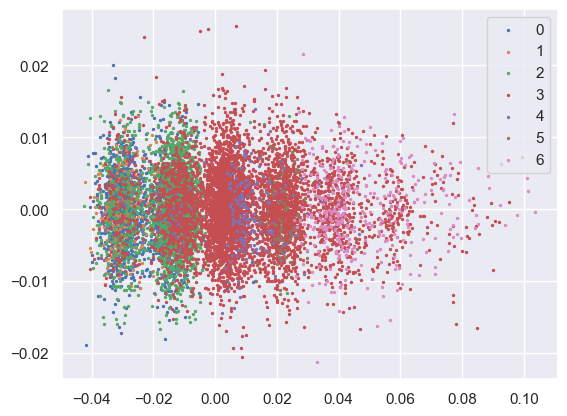

In [6]:
pca_model = PCA(n_components=2)
test_features = pd.DataFrame(pca_model.fit_transform(test_df.values), columns=["first_component", "second_component"])
test_features["y_pred"] = my_model.test_features_df["y_pred"]
for pred_label in set(test_features["y_pred"]):
    plt.scatter(test_features[test_features["y_pred"]==pred_label]["first_component"], test_features[test_features["y_pred"]==pred_label]["second_component"], s=2, label=pred_label)
plt.legend()
plt.show()

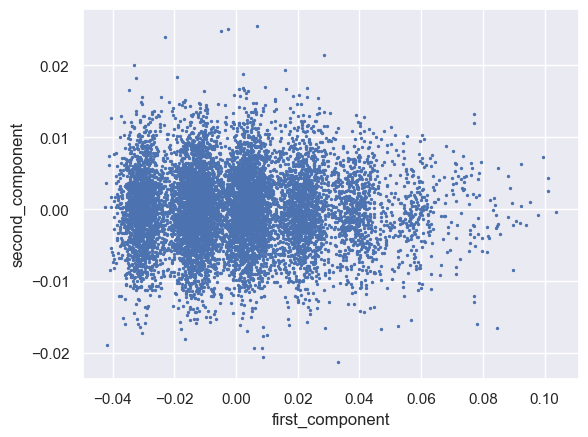

In [7]:
pca_model = PCA(n_components=2)
test_X_pca = pd.DataFrame(pca_model.fit_transform(test_df.values), columns=["first_component", "second_component"])
test_X_pca.plot.scatter(x="first_component", y="second_component", s=2)
plt.show()
